# *Detecting Catfishing and Unhealthy Communication on Social Media by Karan Zaveri*

# Hinglish Conversation Classifier

This notebook demonstrates how to build a classifier for Hinglish conversations, focusing on the classification of text into three categories: `normal`, `toxic`, and `catfish`. The objective of building such a model is to help detect and stop catfishing and toxic conversations across social media platforms. Due to the recent rise in such events, which have led to monetary loss, depression, and other negative impacts, there is a growing need for automated tools to report and mitigate these harmful interactions. The process includes data loading, preprocessing, model training, and evaluation.

C:\Users\91720\AppData\Local\Temp\ipykernel_22616\2911001931.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Encoded_Label'] = label_encoder.fit_transform(data_cleaned['Label'])
C:\Users\91720\AppData\Local\Temp\ipykernel_22616\2911001931.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Processed_Conversation'] = data_cleaned['Conversation'].apply(preprocess_text)


Test Set Accuracy: 0.92


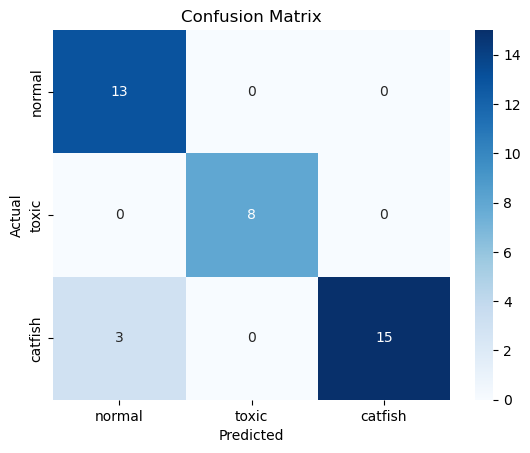

              precision    recall  f1-score   support

      normal       0.81      1.00      0.90        13
       toxic       1.00      1.00      1.00         8
     catfish       1.00      0.83      0.91        18

    accuracy                           0.92        39
   macro avg       0.94      0.94      0.94        39
weighted avg       0.94      0.92      0.92        39



In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load the cleaned dataset from CSV
data = pd.read_excel('Cleaned_Hinglish_Conversations.xlsx')

# Ensure only valid labels are kept
valid_labels = ['normal', 'toxic', 'catfish']
data_cleaned = data[data['Label'].isin(valid_labels)]

# Encode the labels
label_encoder = LabelEncoder()
data_cleaned['Encoded_Label'] = label_encoder.fit_transform(data_cleaned['Label'])

# Preprocess the conversation text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    return text

data_cleaned['Processed_Conversation'] = data_cleaned['Conversation'].apply(preprocess_text)

# Split the dataset into training and testing sets
X = data_cleaned['Processed_Conversation']
y = data_cleaned['Encoded_Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = make_pipeline(TfidfVectorizer(), LogisticRegression())
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = model.score(X_test, y_test)
print(f"Test Set Accuracy: {accuracy:.2f}")

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=label_encoder.transform(valid_labels))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=valid_labels, yticklabels=valid_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Generate the classification report
report = classification_report(y_test, y_pred, labels=label_encoder.transform(valid_labels), target_names=valid_labels)
print(report)


In [2]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

# Print the cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation accuracy: {cv_scores.mean():.2f}")

Cross-validation scores: [0.92307692 0.92105263 0.73684211 0.89473684 0.57894737]
Mean cross-validation accuracy: 0.81


In [3]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
    'tfidfvectorizer__max_df': [0.5, 0.75, 1.0],
    'tfidfvectorizer__min_df': [1, 2, 5]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.2f}")

# Update the model with the best parameers
best_model = grid_search.best_estimator_

# Evaluate the updated model on the test set
test_accuracy = best_model.score(X_test, y_test)
print(f"Test Set Accuracy with Best Parameters: {test_accuracy:.2f}")

Best parameters found: {'logisticregression__C': 1, 'tfidfvectorizer__max_df': 0.5, 'tfidfvectorizer__min_df': 2, 'tfidfvectorizer__ngram_range': (1, 1)}
Best cross-validation accuracy: 0.95
Test Set Accuracy with Best Parameters: 0.92


In [5]:
def classify_user_input():
    user_input = input("Enter a statement: ")
    processed_input = preprocess_text(user_input)
    prediction = model.predict([processed_input])
    predicted_label = label_encoder.inverse_transform(prediction)[0]
    print(f"The input statement is classified as: {predicted_label}")

# Call the function to classify user input
classify_user_input()

Enter a statement:  mai tumhari life set kar sakta hu


The input statement is classified as: catfish
